# Detecting Credit card fraud using Anomaly Detection algorithms

### The key idea is that instead of using the supervised learning models, we will build a probability of features for the normal transactions. Use the fradulent cases to set a threshold on what we call anomaly. 

Author: Sushant N. More

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc,roc_auc_score, \
roc_curve, recall_score, classification_report, precision_score, f1_score 

Importing data

In [4]:
df = pd.read_csv('./creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
df.shape

(284807, 31)

We already did a detailed data exploration in the CreditCardFraudDetection notebook. 

Here are some of the points we remind ourselves.

1. The data is highly skewed. Out of 284,807 examples only 0.17% are fradulent. 

2. We noticed and reasoned that the time column doesn't have any effect on the transaction being fradulent or not. We drop it. 

3. We do the mean normalization of the amount column to make it amenable to ML techniques. 

4. We had seen that the probability density for features V1 through V28 roughly seems Gaussian

In the present case, the workflow is as follows: 

a) We repeat the steps 2 and 3 above.

b) We separate the normal transactions and do a probability density estimation. 

c) Use cross-validation to figure out the threshold. 

d) Finally test on the test set!

In [8]:
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))

In [9]:
df.columns

Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class', u'normAmount'],
      dtype='object')

In [10]:
dfMod = df.drop(['Time', 'Amount'], axis = 1)

In [11]:
dfMod.columns

Index([u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9', u'V10',
       u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18', u'V19',
       u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27', u'V28',
       u'Class', u'normAmount'],
      dtype='object')

In [218]:
dfMod.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


Let's separate the normal transactions from the fradulent

In [13]:
FraudTransaction = dfMod[dfMod['Class'] == 1]
NormalTransaction = dfMod[dfMod['Class'] == 0]

Note in this case, our training set consists of all normal examples. 
Let's split as follows:

Training set: 60% of the normal data

Cross validation set: 20% of normal data, 50% of fradulent data. 

Training set: 20% of normal data, 50% of fradulent data.

Before making this split, we randomly shuffle the data using the sample method of pandas and then apply np.split

In [15]:
len(NormalTransaction)

284315

In [16]:
NormalTransaction.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [17]:
NormalTransaction.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            284797, 284798, 284799, 284800, 284801, 284802, 284803, 284804,
            284805, 284806],
           dtype='int64', length=284315)

In [18]:
NormalTransactionShuffled = NormalTransaction.sample(frac = 1)

In [19]:
NormalTransactionShuffled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
227143,2.008021,-0.210928,-3.134833,-0.343703,2.597961,3.286339,-0.555582,0.832574,0.677253,-0.655852,...,-0.031826,0.094989,0.072766,0.631860,0.123913,0.659120,-0.022794,-0.035894,0,-0.313249
111151,1.178239,-0.112266,-0.528712,0.055660,-0.067912,-1.110653,0.532842,-0.377442,-0.088516,-0.116822,...,-0.027329,-0.272626,-0.226306,-0.034026,0.574890,1.092502,-0.133263,0.001482,0,0.046379
274188,-0.559310,0.252248,0.718171,-0.061253,1.167424,-0.583950,0.425633,0.035439,-0.653711,-0.226866,...,-0.137535,-0.517707,-0.022232,-0.462955,-0.407223,0.374007,0.067637,0.136836,0,-0.349671
36596,-0.707835,1.119971,1.288918,0.942082,-0.084526,-1.000469,0.756299,-0.238079,-0.299020,0.230965,...,0.138632,0.536785,-0.186578,0.713265,-0.390907,-0.434221,-0.539133,-0.359817,0,-0.311529
123354,-1.386725,1.067763,1.822499,-0.682421,-0.377616,-0.680118,0.282821,0.430088,0.150079,-0.372859,...,0.060073,0.011975,-0.091141,0.443813,-0.236341,-0.925158,-0.202221,-0.115952,0,-0.325283


In [20]:
NormalTransactionShuffled.index

Int64Index([227143, 111151, 274188,  36596, 123354, 188769, 143654, 271800,
            205058, 148641,
            ...
            270192, 169599, 223292, 146892, 284442,  62393, 101240, 116059,
             21779, 193586],
           dtype='int64', length=284315)

In [67]:
NormalTrain, NormalValidate, NormalTest = np.split(NormalTransactionShuffled, \
                                                    [int(0.6 * len(NormalTransactionShuffled)), \
                                                    int(0.8 * len(NormalTransactionShuffled)) 
                                                    ])

In [68]:
NormalTrain.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
227143,2.008021,-0.210928,-3.134833,-0.343703,2.597961,3.286339,-0.555582,0.832574,0.677253,-0.655852,...,-0.031826,0.094989,0.072766,0.631860,0.123913,0.659120,-0.022794,-0.035894,0,-0.313249
111151,1.178239,-0.112266,-0.528712,0.055660,-0.067912,-1.110653,0.532842,-0.377442,-0.088516,-0.116822,...,-0.027329,-0.272626,-0.226306,-0.034026,0.574890,1.092502,-0.133263,0.001482,0,0.046379
274188,-0.559310,0.252248,0.718171,-0.061253,1.167424,-0.583950,0.425633,0.035439,-0.653711,-0.226866,...,-0.137535,-0.517707,-0.022232,-0.462955,-0.407223,0.374007,0.067637,0.136836,0,-0.349671
36596,-0.707835,1.119971,1.288918,0.942082,-0.084526,-1.000469,0.756299,-0.238079,-0.299020,0.230965,...,0.138632,0.536785,-0.186578,0.713265,-0.390907,-0.434221,-0.539133,-0.359817,0,-0.311529
123354,-1.386725,1.067763,1.822499,-0.682421,-0.377616,-0.680118,0.282821,0.430088,0.150079,-0.372859,...,0.060073,0.011975,-0.091141,0.443813,-0.236341,-0.925158,-0.202221,-0.115952,0,-0.325283


In [70]:
len(NormalTrain) + len(NormalValidate) + len(NormalTest) 

284315

In [28]:
len(NormalTransaction)

284315

For the Fraud transactions, we can conveniently use the test_train split function from the sci-kit learn

In [29]:
FraudValidate, FraudTest = train_test_split(FraudTransaction, test_size = 0.5)

In [30]:
FraudValidate.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
252774,-1.201398,4.864535,-8.328823,7.652399,-0.167445,-2.767695,-3.176421,1.623279,-4.367228,-5.533443,...,0.532320,-0.556913,0.192444,-0.698588,0.025003,0.514968,0.378105,-0.053133,1,-0.350151
46918,-4.423508,1.648048,-6.934388,4.894601,-5.078131,0.010849,-3.409096,1.409291,-3.260672,-7.781353,...,0.698359,0.487478,1.228698,-0.535217,0.388278,-0.009466,2.300164,0.081231,1,2.237530
263080,2.132386,0.705608,-3.530759,0.514779,1.527175,-1.716268,1.132791,-0.574214,0.128904,-1.000805,...,0.163739,0.703910,-0.245076,0.460049,0.920281,-0.216586,-0.026219,-0.025001,1,-0.349231
9035,-2.589617,7.016714,-13.705407,10.343228,-2.954461,-3.055116,-9.301289,3.349573,-5.654212,-11.853867,...,1.887738,0.333998,0.287659,-1.186406,-0.690273,0.631704,1.934221,0.789687,1,-0.349231
6899,-2.661802,5.856393,-7.653616,6.379742,-0.060712,-3.131550,-3.103570,1.778492,-3.831154,-7.191604,...,0.734775,-0.435901,-0.384766,-0.286016,1.007934,0.413196,0.280284,0.303937,1,-0.349231


In [31]:
len(FraudValidate)

246

In [32]:
len(FraudTest)

246

In [33]:
len(FraudTransaction)

492

Great, now let's model a probability distribution based on the normal examples in the training set. 

In [45]:
mu = NormalTrain.drop('Class', axis = 1).mean(axis = 0).values

In [46]:
mu

array([ 0.01454376, -0.00489052,  0.01024795, -0.00760175,  0.00357395,
        0.00314653,  0.00710655,  0.00067526,  0.00548902,  0.00793077,
       -0.00931862,  0.01185401,  0.00201089,  0.01150641, -0.00016354,
        0.0053953 ,  0.01247777,  0.00328759, -0.00268081, -0.00216582,
       -0.00294412,  0.0003498 , -0.00194123, -0.00103484,  0.00110445,
        0.00017356, -0.00153843,  0.00016741, -0.00239629])

In [51]:
Sigma = NormalTrain.drop('Class', axis = 1).cov().values

In [52]:
Sigma

array([[  3.72383943e+00,   4.98056772e-02,  -1.20253716e-01,
          6.47032573e-02,  -6.69683794e-02,  -2.03540491e-02,
         -1.19218445e-01,  -1.46868367e-02,  -4.18952552e-02,
         -8.35177645e-02,   4.34310395e-02,  -8.24347776e-02,
         -4.35948797e-04,  -7.04988450e-02,  -1.98384677e-03,
         -5.69897335e-02,  -1.07574914e-01,  -3.90558920e-02,
          1.32399132e-02,   1.33182573e-02,   2.31712203e-03,
         -8.34174264e-04,   2.19031996e-02,   9.22886948e-04,
          5.45562432e-03,   1.54939939e-03,   1.77006833e-02,
         -2.31847749e-02,  -4.31854759e-01],
       [  4.98056772e-02,   2.64486642e+00,   8.23263752e-02,
         -3.13171963e-02,   5.35054899e-02,   5.53683809e-03,
          7.68421477e-02,   8.38621869e-03,   2.23048775e-02,
          4.60994291e-02,  -3.51916284e-02,   5.70897630e-02,
         -2.42998416e-03,   6.37128938e-02,   5.16634028e-03,
          4.39446559e-02,   7.42052702e-02,   2.91739261e-02,
         -2.19650501e-03,

In [53]:
Sigma.shape

(29, 29)

In [54]:
model = multivariate_normal(cov=Sigma, mean=mu)

In [55]:
model

In [63]:
model.pdf(0.1), model.pdf(1) 

(3.3748177797006406e-10, 2.3051335684159874e-30)

In [58]:
model.logpdf(0.1)

-21.809509598273351

Since, the probabilities here are very small number, we work with logarithms

In [64]:
np.median(model.logpdf(NormalTrain.drop('Class', axis=1).values))

-30.040188639211298

In [66]:
np.median(model.logpdf(NormalValidate.drop('Class', axis=1).values))

-30.056938322493451

In [71]:
np.median(model.logpdf(NormalTest.drop('Class', axis=1).values))

-30.062984443568425

In [72]:
np.median(model.logpdf(FraudTest.drop('Class', axis=1).values))

-704.52681524032346

In [73]:
np.median(model.logpdf(FraudValidate.drop('Class', axis=1).values))

-643.73247494767838

In [74]:
np.mean(model.logpdf(NormalTrain.drop('Class', axis=1).values))

-35.871605067214496

In [75]:
np.mean(model.logpdf(NormalTest.drop('Class', axis=1).values))

-35.753182475971776

In [76]:
np.mean(model.logpdf(NormalValidate.drop('Class', axis=1).values))

-36.11508558415504

In [77]:
np.mean(model.logpdf(FraudTest.drop('Class', axis=1).values))

-1668.5579545688915

In [78]:
np.mean(model.logpdf(FraudValidate.drop('Class', axis=1).values))

-1566.1077589772622

It's clear that the Fraud examples are prominently in the tail

In [79]:
np.min(model.logpdf(NormalTrain.drop('Class', axis=1).values))

-7575.433100764606

In [80]:
np.max(model.logpdf(FraudValidate.drop('Class', axis=1).values))

-26.474251406819874

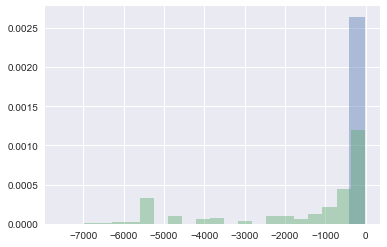

In [246]:
sns.distplot(model.logpdf(NormalTrain.drop('Class', axis=1).values), bins = 20, norm_hist=True, kde=False);
sns.distplot(model.logpdf(FraudValidate.drop('Class', axis=1).values), bins = 20, norm_hist=True, kde=False);

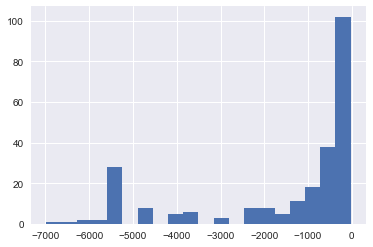

In [233]:
plt.hist(model.logpdf(FraudValidate.drop('Class', axis=1).values), bins = 20);

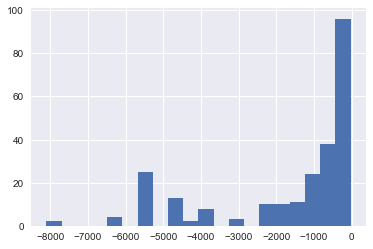

In [89]:
plt.hist(model.logpdf(FraudTest.drop('Class', axis=1).values), bins = 20);

We immediately see a problem. The anomalous examples have a feature distribution which is not in the tails and at the same time, normal examples could also have a feature distribution which is in the tails.

Nonetheless, let's go ahead and look at the precision/ recall scores as a function of threshold. And remember we will be doing this on the cross validation set. Note to build our validation set, we concatenate the normal and fraud examples in the validation set. 

In [96]:
(model.logpdf(FraudValidate.drop('Class', axis=1).values) < -100).astype(int)

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])

In [97]:
Validate = pd.concat([NormalValidate, FraudValidate])

In [99]:
Validate.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
83396,0.838976,-1.312336,0.479948,-1.268141,-1.405630,-0.355518,-0.540094,0.092694,1.786481,-1.067959,...,0.264879,0.479762,-0.337600,0.069668,0.396941,0.096965,-0.003580,0.045458,0,0.514355
267088,2.151710,-0.805652,-0.730330,-0.618679,-0.535349,0.078233,-0.833660,-0.054197,-0.156326,0.765813,...,-0.656489,-1.329040,0.450422,0.057924,-0.614261,0.236217,-0.014512,-0.034251,0,-0.269509
62489,1.065918,-0.701800,0.585918,-0.215388,-0.485223,1.029476,-0.793134,0.381710,0.893662,-0.298974,...,-0.068993,-0.172295,-0.134280,-1.055628,0.138537,1.066278,-0.037146,0.004392,0,-0.013592
24202,-1.773704,1.272402,-1.544407,-3.802906,2.225204,3.694046,-0.880167,-4.234330,1.451294,-0.809141,...,4.475575,-1.367460,0.303548,0.990597,0.039447,-0.166861,0.537489,0.002988,0,-0.113344
195982,-0.415784,1.131399,-0.317913,-0.987318,0.773693,0.081082,0.271282,-1.506520,0.035813,-0.071557,...,1.240946,-1.240830,0.167143,-1.097380,-0.375726,0.199518,0.305005,0.091164,0,-0.349671


In [215]:
NormalValidate.shape

(56863, 30)

In [216]:
FraudValidate.shape

(246, 30)

In [217]:
Validate.shape

(57109, 30)

In [100]:
Validate.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
220725,-1.169203,1.863414,-2.515135,5.463681,-0.297971,1.364918,0.759219,-0.118861,-2.293921,-0.423784,...,-0.393090,-0.708692,0.471309,-0.078616,-0.544655,0.014777,-0.240930,-0.781055,1,0.944509
251881,1.868226,1.363077,-1.994934,4.173516,1.239751,-0.746186,0.572731,-0.131235,-1.551839,0.228849,...,-0.301001,-0.818972,0.206812,-0.263683,-0.114958,-0.240672,-0.006629,0.017258,1,-0.340675
42756,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,6.428169,-7.368451,-12.888158,...,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908,1,-0.353229
143728,-1.756712,3.266574,-4.153388,3.924526,-1.753772,-1.005787,-4.313217,1.560712,-3.295674,-6.213355,...,0.911427,0.053061,-0.367701,-0.776338,0.292094,0.026000,1.062968,0.501148,1,-0.349231
153823,-19.641857,14.706335,-22.801238,12.114672,-14.898113,0.840778,-28.011293,-11.919639,-8.960922,-18.913243,...,-8.228874,3.318178,2.585212,0.195009,-1.194803,0.038423,-4.126746,-0.645329,1,-0.344114


Looking at the histograms above, we see that we can set the lowest threshold (on logprobability) at -1000 and work our way upwards. 

In [117]:
thresholds = np.linspace(-1000,-10, 400)

In [118]:
scores = []
for threshold in thresholds:
    y_hat = (model.logpdf(Validate.drop('Class', axis = 1).values) < threshold).astype(int)
    scores.append([recall_score(y_pred = y_hat, y_true = Validate['Class'].values), \
                  precision_score(y_pred = y_hat, y_true = Validate['Class'].values), \
                  f1_score(y_pred = y_hat, y_true = Validate['Class'].values)])

In [119]:
scores = np.array(scores)

In [120]:
scores

array([[ 0.35772358,  0.73333333,  0.48087432],
       [ 0.35772358,  0.73333333,  0.48087432],
       [ 0.35772358,  0.73333333,  0.48087432],
       ..., 
       [ 1.        ,  0.00430755,  0.00857815],
       [ 1.        ,  0.00430755,  0.00857815],
       [ 1.        ,  0.00430755,  0.00857815]])

In [121]:
scores[:, 2].max() # Best F1 score

0.63687150837988837

In [122]:
scores[:, 2].argmax()

271

In [125]:
thresholds[271]

-327.59398496240601

In [126]:
scores[271, 1] # precision for the best F1 score

0.58762886597938147

In [127]:
scores[271, 0] # recall for the best F1 score

0.69512195121951215

Let's plot precision, recall, and F1 score as a function of threshold. 

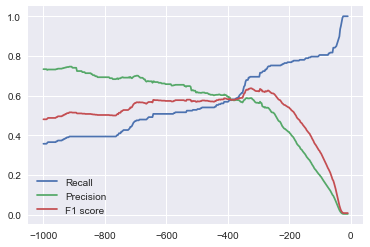

In [138]:
plt.plot(thresholds, scores[:, 0], label = 'Recall');
plt.plot(thresholds, scores[:, 1], label = 'Precision');
plt.plot(thresholds, scores[:, 2], label = 'F1 score');
plt.legend(loc = 'lower left');

In this case, we want recall to be high. We want false negatives to be as low as possible. Let's choose threshold corresponding to recall = 80% and recall = 90 % and see the prediction on the test set. 

In [171]:
np.where(np.logical_and(scores[:, 0] > 0.798, scores[:, 0] < 0.801) == True)[0]

array([361])

In [172]:
index80 = np.where(np.logical_and(scores[:, 0] > 0.798, scores[:, 0] < 0.801) == True)[0][0]

In [173]:
threshold80 = thresholds[index80]

In [174]:
threshold80

-104.28571428571433

In [176]:
index90 = np.where(np.logical_and(scores[:, 0] > 0.898, scores[:, 0] < 0.901) == True)[0][0]

In [177]:
threshold90 = thresholds[index90]

In [178]:
threshold90

-37.29323308270682

Before, we move on to the test set, let's plot confusion matrix for the cross validation set with these two thresholds. 

In [179]:
yPred80 = (model.logpdf(Validate.drop('Class', axis = 1).values) < threshold80).astype(int)

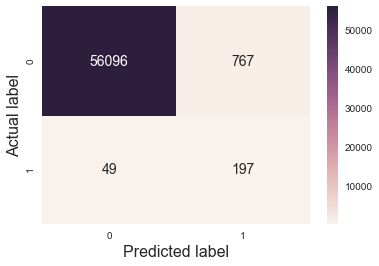

In [189]:
sns.heatmap(confusion_matrix(Validate['Class'].values, yPred80), annot=True, fmt = '.0f', annot_kws={'size': 14});
plt.xlabel('Predicted label', fontsize = 16);
plt.ylabel('Actual label', fontsize = 16);

In [192]:
recall_score(y_pred = yPred80, y_true = Validate['Class'].values)

0.80081300813008127

Note if not preceded by y_pred and y_true, then the default arguments are given in the opposite order. 

In [193]:
precision_score(y_pred = yPred80, y_true = Validate['Class'].values)

0.20435684647302904

In [194]:
f1_score(y_pred = yPred80, y_true = Validate['Class'].values)

0.32561983471074379

Let's now look at the confusion matrix with the threshold at recall = 0.9

In [195]:
yPred90 = (model.logpdf(Validate.drop('Class', axis = 1).values) < threshold90).astype(int)

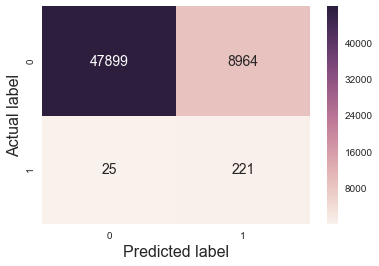

In [196]:
sns.heatmap(confusion_matrix(Validate['Class'].values, yPred90), annot=True, fmt = '.0f', annot_kws={'size': 14});
plt.xlabel('Predicted label', fontsize = 16);
plt.ylabel('Actual label', fontsize = 16);

In [197]:
recall_score(y_pred = yPred90, y_true = Validate['Class'].values)

0.89837398373983735

Note if not preceded by y_pred and y_true, then the default arguments are given in the opposite order. 

In [198]:
precision_score(y_pred = yPred90, y_true = Validate['Class'].values)

0.024060968971148611

In [199]:
f1_score(y_pred = yPred90, y_true = Validate['Class'].values)

0.046866716148870745

Now, cometh the moment of reckoning! Test on the test set first with threshold80 and then with threshold90

In [200]:
Test = pd.concat([NormalTest, FraudTest])

In [202]:
yPredTest80 = (model.logpdf(Test.drop('Class', axis = 1).values) < threshold80).astype(int)

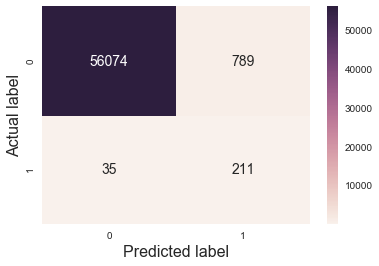

In [203]:
sns.heatmap(confusion_matrix(Test['Class'].values, yPredTest80), annot=True, fmt = '.0f', annot_kws={'size': 14});
plt.xlabel('Predicted label', fontsize = 16);
plt.ylabel('Actual label', fontsize = 16);

In [204]:
recall_score(y_pred = yPredTest80, y_true = Validate['Class'].values)

0.85772357723577231

Note if not preceded by y_pred and y_true, then the default arguments are given in the opposite order. 

In [205]:
precision_score(y_pred = yPredTest80, y_true = Validate['Class'].values)

0.21099999999999999

In [206]:
f1_score(y_pred = yPredTest80, y_true = Validate['Class'].values)

0.33868378812199035

In [207]:
yPredTest90 = (model.logpdf(Test.drop('Class', axis = 1).values) < threshold90).astype(int)

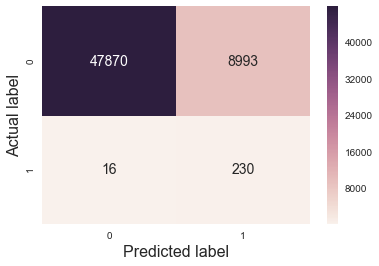

In [208]:
sns.heatmap(confusion_matrix(Test['Class'].values, yPredTest90), annot=True, fmt = '.0f', annot_kws={'size': 14});
plt.xlabel('Predicted label', fontsize = 16);
plt.ylabel('Actual label', fontsize = 16);

In [212]:
recall_score(y_pred = yPredTest90, y_true = Test['Class'].values)

0.93495934959349591

Note if not preceded by y_pred and y_true, then the default arguments are given in the opposite order. 

In [214]:
precision_score(y_pred = yPredTest90, y_true = Test['Class'].values)

0.024937655860349128

In [213]:
f1_score(y_pred = yPredTest90, y_true = Test['Class'].values)

0.048579575456753614

In CreditCardFraudDetection notebook we figured out some irrelevant features. These were the features which had the same distribution for the normal case as well as the Fraud case. We will now repeat the above algorithm but keeping just the relevant features.

In [228]:
irrelevant_features = ['V8', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', \
       'V25', 'V26', 'V27', 'V28', 'normAmount']

In [229]:
NormalTrainRelevant = NormalTrain.drop(irrelevant_features, axis = 1)

In [230]:
NormalTrainRelevant.head()

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,Class
227143,2.008021,-0.210928,-3.134833,-0.343703,2.597961,3.286339,-0.555582,0.677253,-0.655852,0.179464,0.088953,-1.490181,0.044431,1.158024,0.060989,0
111151,1.178239,-0.112266,-0.528712,0.055660,-0.067912,-1.110653,0.532842,-0.088516,-0.116822,-0.722735,-0.125094,0.516403,0.075409,-0.323107,-0.482312,0
274188,-0.559310,0.252248,0.718171,-0.061253,1.167424,-0.583950,0.425633,-0.653711,-0.226866,0.471095,0.354891,0.553827,-0.316471,-0.234368,0.037388,0
36596,-0.707835,1.119971,1.288918,0.942082,-0.084526,-1.000469,0.756299,-0.299020,0.230965,-0.310085,-0.430031,0.343574,-0.448470,-0.078769,0.059322,0
123354,-1.386725,1.067763,1.822499,-0.682421,-0.377616,-0.680118,0.282821,0.150079,-0.372859,0.815234,-0.052907,0.456167,1.259566,-1.290635,0.642667,0


In [257]:
NormalValidateRelevant = NormalValidate.drop(irrelevant_features, axis = 1)
NormalTestRelevant = NormalTest.drop(irrelevant_features, axis = 1)
FraudValidateRelevant = FraudValidate.drop(irrelevant_features, axis = 1)
FraudTestRelevant = FraudTest.drop(irrelevant_features, axis = 1)

In [258]:
muRel = NormalTrainRelevant.drop('Class', axis = 1).mean(axis = 0).values

In [259]:
SigmaRel = NormalTrainRelevant.drop('Class', axis = 1).cov().values

In [260]:
modelRel = multivariate_normal(cov=SigmaRel, mean=muRel)

Since, the probabilities here are very small number, we work with logarithms

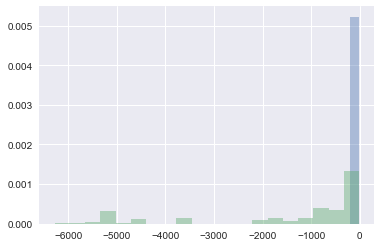

In [261]:
sns.distplot(modelRel.logpdf(NormalTrainRelevant.drop('Class', axis=1).values), bins = 20, norm_hist=True, kde=False);
sns.distplot(modelRel.logpdf(FraudValidateRelevant.drop('Class', axis=1).values), bins = 20, norm_hist=True, kde=False);

Compare the graph above to the graph below. It seems like we were marginally successful in driving out some of the anomalies to the tail region.

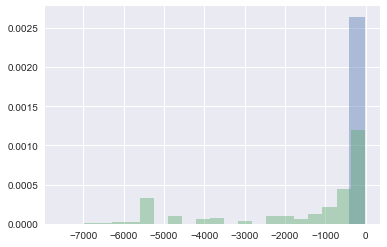

In [265]:
sns.distplot(model.logpdf(NormalTrain.drop('Class', axis=1).values), bins = 20, norm_hist=True, kde=False);
sns.distplot(model.logpdf(FraudValidate.drop('Class', axis=1).values), bins = 20, norm_hist=True, kde=False);

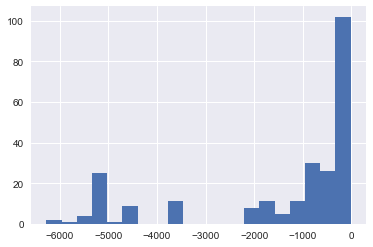

In [262]:
plt.hist(modelRel.logpdf(FraudValidateRelevant.drop('Class', axis=1).values), bins = 20);

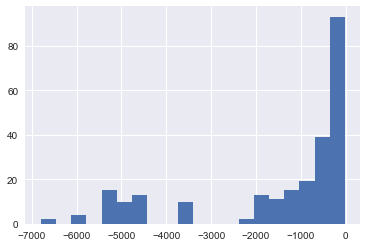

In [264]:
plt.hist(modelRel.logpdf(FraudTestRelevant.drop('Class', axis=1).values), bins = 20);

In [266]:
ValidateRelevant = pd.concat([NormalValidateRelevant, FraudValidateRelevant])

In [267]:
scoresRel = []
for threshold in thresholds:
    y_hat = (modelRel.logpdf(ValidateRelevant.drop('Class', axis = 1).values) < threshold).astype(int)
    scoresRel.append([recall_score(y_pred = y_hat, y_true = ValidateRelevant['Class'].values), \
                  precision_score(y_pred = y_hat, y_true = ValidateRelevant['Class'].values), \
                  f1_score(y_pred = y_hat, y_true = ValidateRelevant['Class'].values)])

In [268]:
scoresRel = np.array(scoresRel)

In [271]:
scoresRel[:, 2].max() # Best F1 score

0.76288659793814428

In [272]:
scoresRel[:, 2].argmax()

307

In [274]:
thresholds[307]

-238.27067669172936

In [275]:
scoresRel[307, 1] # precision for the best F1 score

0.77405857740585771

In [276]:
scoresRel[307, 0] # recall for the best F1 score

0.75203252032520329

Let's plot precision, recall, and F1 score as a function of threshold. 

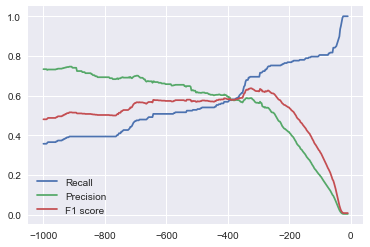

In [278]:
plt.plot(thresholds, scores[:, 0], label = 'Recall');
plt.plot(thresholds, scores[:, 1], label = 'Precision');
plt.plot(thresholds, scores[:, 2], label = 'F1 score');
plt.legend(loc = 'lower left');

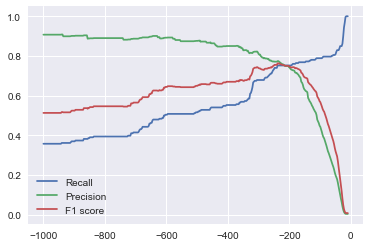

In [277]:
plt.plot(thresholds, scoresRel[:, 0], label = 'Recall');
plt.plot(thresholds, scoresRel[:, 1], label = 'Precision');
plt.plot(thresholds, scoresRel[:, 2], label = 'F1 score');
plt.legend(loc = 'lower left');

Note how this model is better than the previous one in that it gives a better F1 score.

Let's again play the threshold80, threshold90 game with model built from relevant features. As before first we do it on the cross validation set. 

In [291]:
np.where(np.logical_and(scoresRel[:, 0] > 0.7999999, scoresRel[:, 0] < 0.80088) == True)[0]

array([378, 379])

In [292]:
index80rel = np.where(np.logical_and(scoresRel[:, 0] > 0.7999999, scoresRel[:, 0] < 0.80088) == True)[0][0]

In [293]:
index80rel

378

In [294]:
threshold80rel = thresholds[index80rel]

In [295]:
threshold80rel

-62.105263157894797

In [297]:
index90rel = np.where(np.logical_and(scoresRel[:, 0] > 0.898, scoresRel[:, 0] < 0.901) == True)[0][0]

In [298]:
threshold90rel = thresholds[index90rel]

In [299]:
threshold90rel

-24.887218045112832

Before, we move on to the test set, let's plot confusion matrix for the cross validation set with these two thresholds. 

In [301]:
yPred80rel = (modelRel.logpdf(ValidateRelevant.drop('Class', axis = 1).values) < threshold80rel).astype(int)

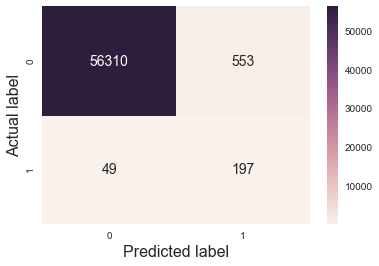

In [302]:
sns.heatmap(confusion_matrix(ValidateRelevant['Class'].values, yPred80rel), \
            annot=True, fmt = '.0f', annot_kws={'size': 14});
plt.xlabel('Predicted label', fontsize = 16);
plt.ylabel('Actual label', fontsize = 16);

In [303]:
recall_score(y_pred = yPred80rel, y_true = ValidateRelevant['Class'].values)

0.80081300813008127

In [192]:
recall_score(y_pred = yPred80, y_true = Validate['Class'].values)

0.80081300813008127

In [304]:
precision_score(y_pred = yPred80rel, y_true = ValidateRelevant['Class'].values)

0.26266666666666666

In [193]:
precision_score(y_pred = yPred80, y_true = Validate['Class'].values)

0.20435684647302904

In [305]:
f1_score(y_pred = yPred80rel, y_true = ValidateRelevant['Class'].values)

0.39558232931726911

In [308]:
f1_score(y_pred = yPred80, y_true = Validate['Class'].values)

0.32561983471074379

Let's now look at the confusion matrix with the threshold at recall = 0.9

In [309]:
yPred90rel = (modelRel.logpdf(ValidateRelevant.drop('Class', axis = 1).values) < threshold90rel).astype(int)

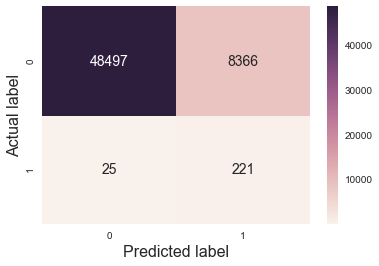

In [310]:
sns.heatmap(confusion_matrix(ValidateRelevant['Class'].values, yPred90rel), annot=True, fmt = '.0f', 
            annot_kws={'size': 14});
plt.xlabel('Predicted label', fontsize = 16);
plt.ylabel('Actual label', fontsize = 16);

In [311]:
recall_score(y_pred = yPred90rel, y_true = ValidateRelevant['Class'].values)

0.89837398373983735

In [312]:
precision_score(y_pred = yPred90rel, y_true = ValidateRelevant['Class'].values)

0.025736578548969373

In [314]:
precision_score(y_pred = yPred90, y_true = Validate['Class'].values)

0.024060968971148611

In [315]:
f1_score(y_pred = yPred90rel, y_true = ValidateRelevant['Class'].values)

0.050039624136759879

In [316]:
f1_score(y_pred = yPred90, y_true = Validate['Class'].values)

0.046866716148870745